# Synthetic Payment Fraud - EDA

## Load packages and data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import scipy.stats
from scipy import stats
pd.options.display.float_format = '{:.2f}'.format ## override scientific notation

In [2]:
df = pd.read_csv('processed_data.csv').drop(['Unnamed: 0'],axis=1)

In [4]:
# one hot encoding type column because it is a categorical variable
type_dummies = pd.get_dummies(df['type'])
df = pd.concat([df,type_dummies],axis=1).drop(['type'],axis=1)

In [5]:
df.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.00,160296.36,0.00,0.00,0,0,0,0,1,0
1,1864.28,21249.00,19384.72,0.00,0.00,0,0,0,0,1,0
2,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,1
3,181.00,181.00,0.00,21182.00,0.00,1,0,1,0,0,0
4,11668.14,41554.00,29885.86,0.00,0.00,0,0,0,0,1,0


## Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   amount          float64
 1   oldbalanceOrg   float64
 2   newbalanceOrig  float64
 3   oldbalanceDest  float64
 4   newbalanceDest  float64
 5   isFraud         int64  
 6   CASH_IN         uint8  
 7   CASH_OUT        uint8  
 8   DEBIT           uint8  
 9   PAYMENT         uint8  
 10  TRANSFER        uint8  
dtypes: float64(5), int64(1), uint8(5)
memory usage: 321.6 MB


In [7]:
df.count()

amount            6362620
oldbalanceOrg     6362620
newbalanceOrig    6362620
oldbalanceDest    6362620
newbalanceDest    6362620
isFraud           6362620
CASH_IN           6362620
CASH_OUT          6362620
DEBIT             6362620
PAYMENT           6362620
TRANSFER          6362620
dtype: int64

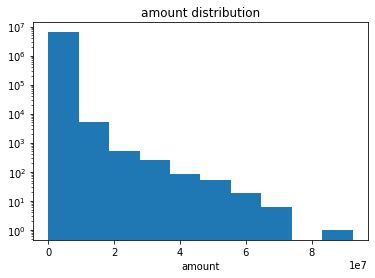

In [8]:
plt.hist(x='amount',data=df,log=True)
plt.xlabel('amount')
plt.title('amount distribution')
plt.show()

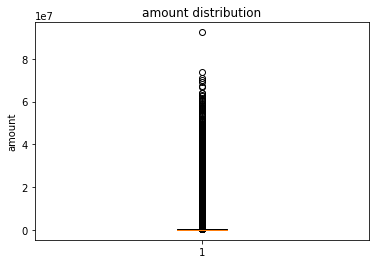

In [9]:
plt.boxplot(df['amount'])
plt.ylabel('amount')
plt.title('amount distribution')
plt.show()

Based on the boxplot and histogram charts, this confirms that there is significant skew in the amount data

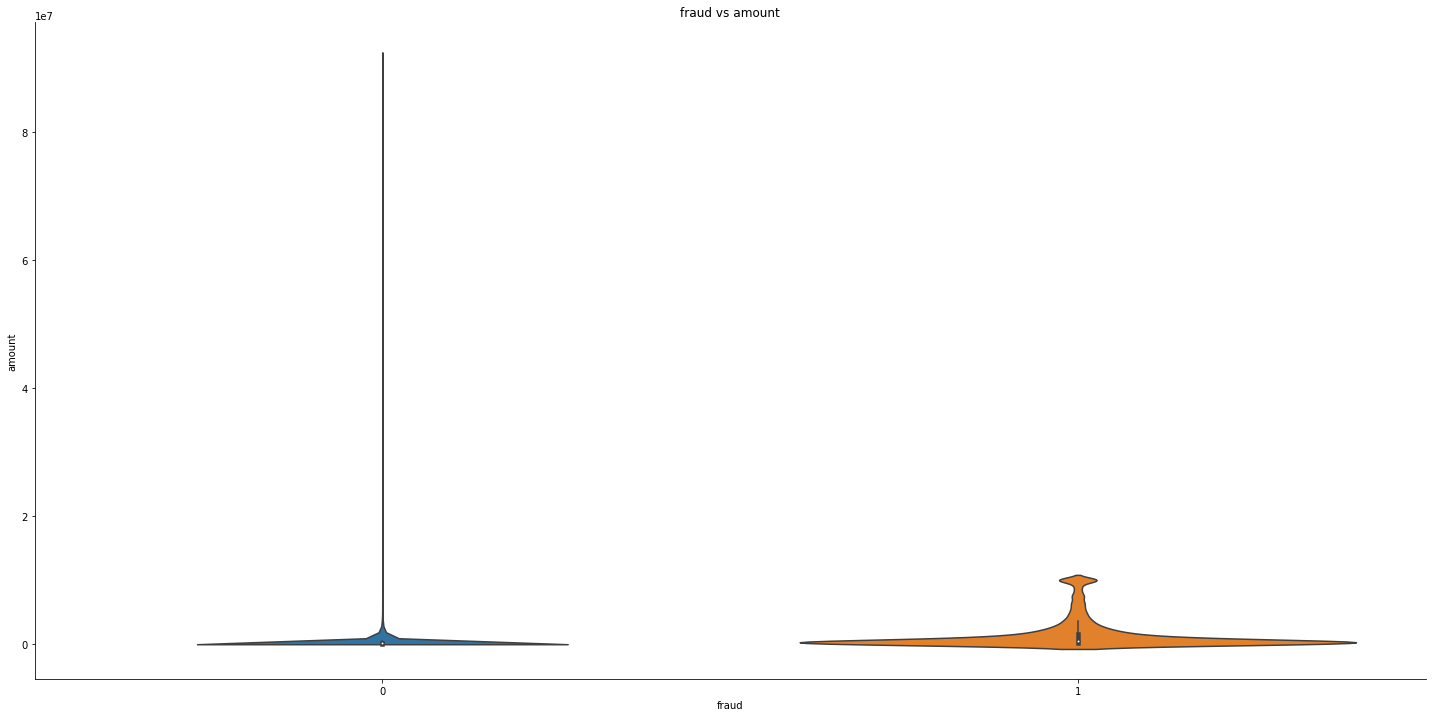

In [10]:
sns.catplot(x='isFraud',y='amount',data=df,height=10,kind='violin',aspect=2)
plt.xlabel('fraud')
plt.ylabel('amount')
plt.title('fraud vs amount')
plt.show()

Based on this catplot, we can see that the fraud usually occurs below 2 million dollars

In [11]:
# look at what the average fraud amount is
df[df['isFraud']==1]['amount'].mean()

1467967.299140387

In [12]:
# look at what percent of the fraud labels have an outlier amount of $10 million
len(df[(df['isFraud']==1) & (df['amount']>=10000000.0)]) / len(df[(df['isFraud']==1)])

0.03494460002435164

3.5% of the fraudulent records have an amount equal to or over 10 million dollars and the mean fraud amount is around 1.5 million dollars

<AxesSubplot:>

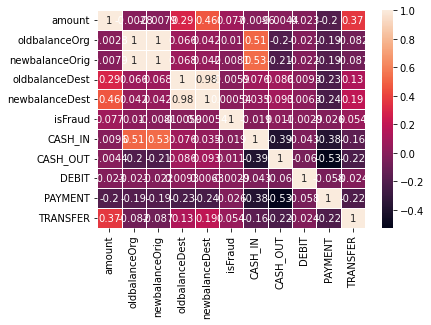

In [13]:
# check correlation heat map against variables
sns.heatmap(df.corr(method='pearson'),annot=True,linewidth=1)

The top features in this data set now appear to be:
- amount: 0.077
- TRANSFER: 0.054
- PAYMENT: 0.026

Everything else seems to have a relatively low pearson correlation in regards to the fraud label

Things to think about:

- Will we be able to successfully predict fraud with low correlated variables?
- If we can't, should we randomly remove some non fraudulent records to upsample for fraud?

In [14]:
df.groupby('isFraud').describe()

amount                                                            \
             count       mean        std  min       25%       50%        75%   
isFraud                                                                        
0       6354407.00  178197.04  596236.98 0.01  13368.40  74684.72  208364.76   
1          8213.00 1467967.30 2404252.95 0.00 127091.33 441423.44 1517771.48   

                    oldbalanceOrg             ... PAYMENT        TRANSFER  \
                max         count       mean  ...     75%  max      count   
isFraud                                       ...                           
0       92445516.64    6354407.00  832828.71  ...    1.00 1.00 6354407.00   
1       10000000.00       8213.00 1649667.61  ...    0.00 0.00    8213.00   

                                            
        mean  std  min  25%  50%  75%  max  
isFraud                                     
0       0.08 0.28 0.00 0.00 0.00 0.00 1.00  
1       0.50 0.50 0.00 0.00 0.00 1.00 1.00  

[2 rows x 80 columns]

In [15]:
# define useful function to create scatterplots of amount against desired columns
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'amount', data=df, alpha=0.5)
        ax.set(xlabel=col, ylabel='amount')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [16]:
features = [x for x in df.columns]

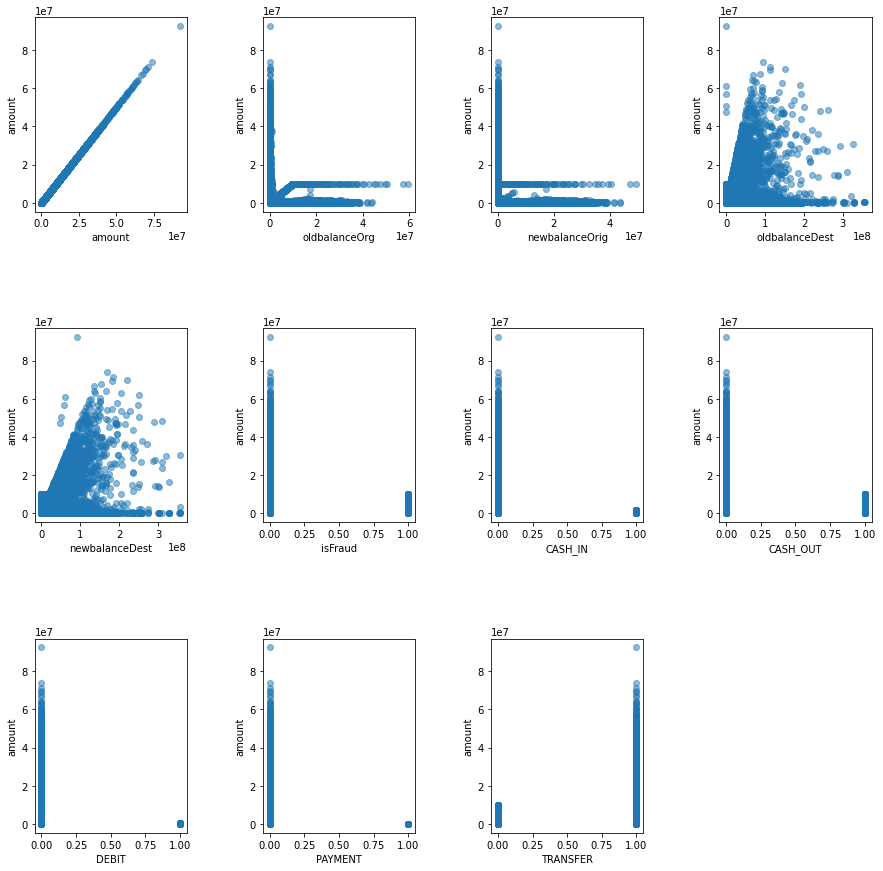

In [17]:
scatterplots(features, ncol=4, figsize=(15, 15))

These scatter plots don't really show too much information that we already figured out from our data wrangling and visualizations from above

# Statistical Analysis

In [18]:
stats.normaltest(df['amount'])

NormaltestResult(statistic=16762631.767949674, pvalue=0.0)

In [19]:
stats.normaltest(df['isFraud'])

NormaltestResult(statistic=15876837.180906821, pvalue=0.0)

In [20]:
stats.normaltest(df['TRANSFER'])

NormaltestResult(statistic=3756981.7677023355, pvalue=0.0)

In [21]:
stats.normaltest(df['PAYMENT'])

NormaltestResult(statistic=35763881.1732996, pvalue=0.0)

With a pvalue of 0 for every single result, we can determine that the data is definitely not normally distributed. I'm almost positive that when we run some initial models to see performance that we will need to upsample for fraud (which I predicted earlier in this notebook)